In [1]:
import pandas as pd
import mplfinance as mpf

In [2]:
import rbot

In [3]:
bb = rbot.DummyBb()
bb.log_load(100)

global_ohlcv=[]


In [4]:
ohlcv = bb.ohlcv(bb.log_start_ms, bb.log_end_ms, 3600*24)
ohlcv_df = pd.DataFrame(ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"]) 
ohlcv_df['timestamp'] = pd.to_datetime((ohlcv_df["timestamp"]), utc=True, unit='ms')
ohlcv_df = ohlcv_df.set_index('timestamp')





In [5]:
ohlcv_df

,open,high,low,close,volume
timestamp,,,,,
2022-03-17 00:00:00+00:00,41122.5,41468.5,40463.5,40908.5,9.543955e+08
2022-03-18 00:00:00+00:00,40908.5,42331.0,40140.0,41766.0,1.535470e+09
2022-03-19 00:00:00+00:00,41765.5,42400.0,41528.0,42215.0,9.719139e+08
2022-03-20 00:00:00+00:00,42215.0,42285.5,40910.0,41267.5,1.183475e+09
2022-03-21 00:00:00+00:00,41268.0,41563.5,40488.0,40994.0,1.353984e+09
...,...,...,...,...,...
2022-06-20 00:00:00+00:00,20534.5,21060.0,19588.5,20540.0,1.516327e+09
2022-06-21 00:00:00+00:00,20539.5,21699.5,20307.5,20694.5,1.325359e+09
2022-06-22 00:00:00+00:00,20692.5,20868.5,19733.5,19962.0,1.417598e+09


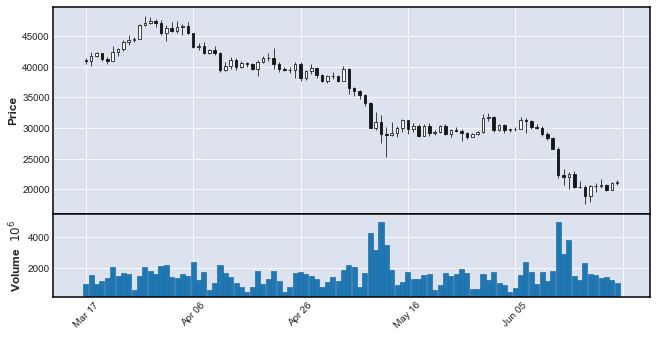

In [6]:

mpf.plot(ohlcv_df, type='candle', volume=True, figratio=(16,8))





In [7]:
class Agent:
    def __init__(self):
            self.ohlcv = ""

    def on_event(self, time_ms, action, price, size):
        pass
        #//print("E", time_ms, action, price, size)

    def on_tick(self, time_ms, session):
        #print("c", time_ms, market.current_time)
        print("start", rbot.PrintTime(time_ms))        
        # TODO: 出たーがなかったときの処理。
        #session.ohlcv(10, 480)
        # print(market.log_start_ms)
        self.ohlcv = session.ohlcv(60, 100)

        #print(ohlcv)
        return rbot.Order("sell", 1000, 100, "MyOrder",  600)

    
    def on_update(self, result):
        print("update", result.status)

In [8]:
agent = Agent()

In [9]:
bb.debug_loop_count = 10

In [10]:
bb.run(agent, 60)

call back tick by 60[sec]
call back by update
call back by all log events
start 2022-03-17-00:01:00.000
update Open
start 2022-03-17-00:02:00.000
update Open
start 2022-03-17-00:03:00.000
updateMake ORDER PyOrder { side: Sell, price: 1000.0, size: 100.0, message: "MyOrder", duration_ms: 600000 }
complete order
Make ORDER PyOrder { side: Sell, price: 1000.0, size: 100.0, message: "MyOrder", duration_ms: 600000 }
complete order
Make ORDER PyOrder { side: Sell, price: 1000.0, size: 100.0, message: "MyOrder", duration_ms: 600000 }
complete order
 Open
start 2022-03-17-00:04:00.000
update Open
start 2022-03-17-00:05:00.000
update Open
start 2022-03-17-00:06:00.000
update OpenMake ORDER PyOrder { side: Sell, price: 1000.0, size: 100.0, message: "MyOrder", duration_ms: 600000 }
complete order
Make ORDER PyOrder { side: Sell, price: 1000.0, size: 100.0, message: "MyOrder", duration_ms: 600000 }
complete order
Make ORDER PyOrder { side: Sell, price: 1000.0, size: 100.0, message: "MyOrder", dura

In [11]:
tr = bb.transactions

In [12]:
import pandas as pd

In [13]:
for item in tr:
    print(item)

In [18]:
timestamp = []
order_id = []
order_sub_id = []
order_type = []
post_only = []
create_time = []
status = []
open_price = []
close_price = []
size = []
volume = []
profit = []
fee = []
total_profit = []
message = []

for item in tr:
    timestamp.append(item.timestamp)
    order_id.append(item.order_id)
    order_sub_id.append(item.order_sub_id)
    order_type.append(item.order_type)
    post_only.append(item.post_only)
    create_time.append(item.create_time)
    status.append(item.status)
    open_price.append(item.open_price)
    close_price.append(item.close_price)
    size.append(item.size)
    volume.append(item.volume)
    profit.append(item.profit)
    fee.append(item.fee)
    total_profit.append(item.total_profit)
    message.append(item.message)





In [19]:
df = pd.DataFrame(
data = {"timestamp": timestamp, "order_id": order_id, "order_sub_id": order_sub_id, 
"order_type": order_type, "post_only": post_only, "create_time": create_time,
"status":  status, "open_price": open_price, "close_price": close_price, 
"size": size, "volume": volume, "profit": profit, "fee": fee,
"total_profit":total_profit, "message": message},
columns = ["timestamp", "order_id", "order_sub_id", "order_type", "post_only",
"create_time", "status", "open_price", "close_price","size", "volume", 
"profit", "fee","total_profit", "message"]
)
df["timestamp"] = pd.to_datetime((df["timestamp"]), utc=True, unit='ms')
df["create_time"] = pd.to_datetime((df["create_time"]), utc=True, unit='ms')


In [20]:
df

,timestamp,order_id,order_sub_id,order_type,post_only,create_time,status,open_price,close_price,size,volume,profit,fee,total_profit,message
0,2022-03-17 00:01:08+00:00,0000-0001,0,Sell,True,2022-03-17 00:00:58+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
1,2022-03-17 00:02:00+00:00,0000-0002,0,Sell,True,2022-03-17 00:01:57+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
2,2022-03-17 00:03:01+00:00,0000-0003,0,Sell,True,2022-03-17 00:02:59+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
3,2022-03-17 00:04:07+00:00,0000-0004,0,Sell,True,2022-03-17 00:03:57+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
4,2022-03-17 00:05:00+00:00,0000-0005,0,Sell,True,2022-03-17 00:04:58+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
5,2022-03-17 00:06:17+00:00,0000-0006,0,Sell,True,2022-03-17 00:05:59+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
6,2022-03-17 00:07:05+00:00,0000-0007,0,Sell,True,2022-03-17 00:06:59+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
7,2022-03-17 00:08:01+00:00,0000-0008,0,Sell,True,2022-03-17 00:07:57+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
8,2022-03-17 00:09:05+00:00,0000-0009,0,Sell,True,2022-03-17 00:08:58+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder
9,2022-03-17 00:10:02+00:00,0000-0010,0,Sell,True,2022-03-17 00:09:59+00:00,Open,1000.0,0.0,100.0,0.1,0.0,0.06,-0.06,MyOrder


In [12]:
global_ohlcv

[]

In [16]:
agent.ohlcv

array([[1.65602868e+12, 2.10965000e+04, 2.10965000e+04, 2.10730000e+04,
        2.10730000e+04, 5.78182000e+05],
       [1.65602862e+12, 2.10750000e+04, 2.11000000e+04, 2.10750000e+04,
        2.10970000e+04, 3.61443000e+05],
       [1.65602856e+12, 2.10775000e+04, 2.10800000e+04, 2.10750000e+04,
        2.10750000e+04, 1.79245000e+05],
       [1.65602850e+12, 2.10690000e+04, 2.10805000e+04, 2.10690000e+04,
        2.10770000e+04, 1.58544000e+05],
       [1.65602844e+12, 2.10705000e+04, 2.10790000e+04, 2.10685000e+04,
        2.10690000e+04, 3.16112000e+05],
       [1.65602838e+12, 2.10555000e+04, 2.10730000e+04, 2.10550000e+04,
        2.10725000e+04, 1.01685000e+05],
       [1.65602832e+12, 2.10300000e+04, 2.10560000e+04, 2.10280000e+04,
        2.10560000e+04, 4.25686000e+05],
       [1.65602826e+12, 2.10560000e+04, 2.10600000e+04, 2.10300000e+04,
        2.10300000e+04, 1.38052400e+06],
       [1.65602820e+12, 2.10645000e+04, 2.10715000e+04, 2.10550000e+04,
        2.10560000e+04, 

In [43]:
#index = range(len(agent.ohlcv))
ohlcv_df = pd.DataFrame(agent.ohlcv, columns=["timestamp", "open", "high", "low", "close", "vol"]) #index=index))
ohlcv_df['timestamp'] = pd.to_datetime((ohlcv_df["timestamp"]), utc=True, unit='ms')
#ohlcv_df = df.sort_values("timestamp", ascending=False)



In [40]:
ohlcv_df

,timestamp,open,high,low,close,vol
0,2022-06-23 23:58:00+00:00,21096.5,21096.5,21073.0,21073.0,578182.0
1,2022-06-23 23:57:00+00:00,21075.0,21100.0,21075.0,21097.0,361443.0
2,2022-06-23 23:56:00+00:00,21077.5,21080.0,21075.0,21075.0,179245.0
3,2022-06-23 23:55:00+00:00,21069.0,21080.5,21069.0,21077.0,158544.0
4,2022-06-23 23:54:00+00:00,21070.5,21079.0,21068.5,21069.0,316112.0
...,...,...,...,...,...,...
95,2022-06-23 22:23:00+00:00,20818.5,20861.0,20815.0,20850.5,906002.0
96,2022-06-23 22:22:00+00:00,20800.5,20831.5,20800.5,20818.0,778014.0
97,2022-06-23 22:21:00+00:00,20797.0,20804.5,20790.0,20797.0,533457.0
98,2022-06-23 22:20:00+00:00,20815.0,20817.0,20790.5,20793.5,1912237.0


In [28]:
ohlcv_df["timestamp"]%1_000_00000

0     28680000.0
1     28620000.0
2     28560000.0
3     28500000.0
4     28440000.0
         ...    
95    22980000.0
96    22920000.0
97    22860000.0
98    22800000.0
99    22740000.0
Name: timestamp, Length: 100, dtype: float64